# MNIST Calculator

This notebook can be used to reproduce all the experiments for the paper _Performing Arithmetic Using a Neural Network Trained on Digit Permutation Pairs_. See <https://link.springer.com/chapter/10.1007/978-3-030-59491-6_24> for details.

First we import the packages we require:

In [1]:
# Keras imports for the convolutional neural network
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import losses
from keras import optimizers
from keras import callbacks

# Additional packages
from PIL import Image
import glob
import os
import numpy as np
from sklearn import utils 
from sklearn.model_selection import KFold
import IPython.display as dp
import matplotlib.pyplot as plt
%matplotlib inline
# plt.rcParams['figure.figsize'] = (18, 6)
from scipy.stats import itemfreq
from math import floor, ceil
import random

## Load and Generate Training and Test Data

Now that the appropriate libraries have been loaded, we will use scikit-learn's built-in MNIST dataset for generating the data in these experiments.

In [2]:
(X_train_keras, y_train_keras), (X_test_keras, y_test_keras) = mnist.load_data()

Once the dataset has been loaded, we can take a look at an image from the dataset like so:

In [3]:
Image.fromarray(X_train_keras[0])

MNIST images are $28 \times 28$ pixels in size, and the combined images that will be used for training and testing will be two MNIST images placed side by side and merged as a single image. The dimensions of a single MNIST image can be seen as follows:

In [4]:
X_train_keras[0].shape

(28, 28)

Therefore, the images used in this experiment will be $28 \times 56$ in size. 

To demonstrate how the combined images look, we can make a random combination and display it inline. First we create an empty $28 \times 56$ image matrix and then populate it with two images from the MNIST training set:

In [5]:
# Create an empty 28 * 56 element matrix
test_image = np.zeros((28,56), dtype="uint8")

# Populate the empty matrix with data from two image matrices from the training set
test_image[:,:28] = X_train_keras[0]
test_image[:,28:] = X_train_keras[1]
Image.fromarray(test_image)

As can be seen, to generate the data we merely combine two MNIST images into one image.

Now we generate our trainging pairs and test pairs **indices**. 

For the digits 0-9, there are 100 possible combinations of digits. More formally, we can say that the left side image can consist of the digits 0-9: $S_l = \{0,1,2,3,4,5,6,7,8,9\}$ and the right side consist of images from the set $S_r = \{0,1,2,3,4,5,6,7,8,9\}$. The total possible number of combinations is the Cartesian product of the two sets $D = S_l \times S_r$. 

Here we first generate all possible pairs of combinations and then randomly select 90% of these for the training set while the remaining 10% are used for the test set:

In [6]:
# Generate the 100 unique pairs
unique_pairs = [str(x)+str(y) for x in range(10) for y in range(10)]

# Create 10 test set pairs
test_set_pairs = []

while(len(test_set_pairs) < 10):
    pair_to_add = random.choice(unique_pairs)
    if pair_to_add not in test_set_pairs:
        test_set_pairs.append(pair_to_add)

#Use the remaining 90 as training set pairs
train_set_pairs = list(set(unique_pairs) - set(test_set_pairs))

We can view the test set and training set pairs to ensure there is no overlap between the two data sets. These will be used later to generate the training and test data (they will be used as indices).

The test looks as follows:

In [7]:
print(test_set_pairs)

['23', '77', '50', '51', '18', '59', '27', '81', '20', '71']


While the training set looks as follows:

In [8]:
print(train_set_pairs)

['19', '76', '99', '14', '34', '08', '74', '60', '78', '96', '80', '29', '88', '38', '44', '10', '94', '57', '02', '21', '68', '73', '41', '58', '07', '45', '12', '15', '97', '22', '31', '95', '43', '83', '62', '06', '64', '93', '82', '25', '85', '47', '26', '56', '69', '32', '84', '05', '40', '37', '86', '72', '52', '39', '91', '87', '24', '42', '04', '35', '17', '55', '75', '54', '11', '46', '49', '48', '90', '89', '00', '65', '13', '53', '98', '79', '30', '36', '09', '01', '61', '03', '66', '33', '70', '67', '16', '63', '92', '28']


Now we can also perform some sanity tests on our data created so far:

In [9]:
# Ensure there are 90 training set pairs and 10 test set pairs
assert(len(test_set_pairs) == 10)
assert(len(train_set_pairs) == 90)

# Ensure no test set pairs appear in the training set pairs:
for test_set in test_set_pairs:
    assert(test_set not in train_set_pairs)
    print("%s not in training set." % test_set)

23 not in training set.
77 not in training set.
50 not in training set.
51 not in training set.
18 not in training set.
59 not in training set.
27 not in training set.
81 not in training set.
20 not in training set.
71 not in training set.


With our permutation pairs, we can begin generating the data.
We use the `train_set_pairs` and `test_set_pairs` arrays as indices to generate data, and in the example below we create 1000 samples for each test and train set permutation pair. So, there are exactly 1000 samples for every premutation, resulting in 100,000 images in total split 90/10 across the train set and test set:

In [10]:
X_train = []
y_train = []

# Number of samples per permutation (e.g. there are 90 permutations in the train set so 1000 * 90)
samples_per_permutation = 10  # Set to 10 for brevity. Results in the paper were for 1,000 samples.

for train_set_pair in train_set_pairs:
    for _ in range(samples_per_permutation):
        rand_i = np.random.choice(np.where(y_train_keras == int(train_set_pair[0]))[0])
        rand_j = np.random.choice(np.where(y_train_keras == int(train_set_pair[1]))[0])
        
        temp_image = np.zeros((28,56), dtype="uint8")
        temp_image[:,:28] = X_train_keras[rand_i]
        temp_image[:,28:] = X_train_keras[rand_j]

        X_train.append(temp_image)
        y_train.append(y_train_keras[rand_i] + y_train_keras[rand_j])
        
X_test = []
y_test = []

for test_set_pair in test_set_pairs:
    for _ in range(samples_per_permutation):
        rand_i = np.random.choice(np.where(y_test_keras == int(test_set_pair[0]))[0])
        rand_j = np.random.choice(np.where(y_test_keras == int(test_set_pair[1]))[0])
        
        temp_image = np.zeros((28,56), dtype="uint8")
        temp_image[:,:28] = X_test_keras[rand_i]
        temp_image[:,28:] = X_test_keras[rand_j]
            
        X_test.append(temp_image)
        y_test.append(y_test_keras[rand_i] + y_test_keras[rand_j])

**Note that for the purposes of brevity, we have generated only 10 samples per permutation pair (see the line `samples_per_permutation = 10` above). For the results reported in the paper this was set to 1,000 samples per permutation pair. To replicate more closely the results in the paper, please adjust accordindingly.**

In the code above, we also generate our labels, which are the sum of the two images contained in each generated image.

Before we preview our data, however, we will ensure we have generated the number of images is correct and that the label data matches the image data sizes:

In [11]:
print("Training set size: %s, test set size: %s" % (len(X_train), len(X_test)))

# The training set should be 90,000 images in size (90 permutations * 1000)
# and the label data, y_train, must also be equal in length.
assert(len(X_train) == samples_per_permutation * 90)
assert(len(X_train) == len(y_train))

# The test set should be 10,000 images in size (10 permutations * 1000)
# and the label data, y_test, must also be equal in length
assert(len(X_test) == samples_per_permutation * 10)
assert(len(X_test) == len(y_test))

Training set size: 900, test set size: 100


Let us also preview a generated image and its label so that we get an understanding of how the dataset looks:

In [12]:
ind = random.randint(0, len(X_test))
print("Image label: " + str(y_test[ind]))
Image.fromarray(X_test[ind])

Image label: 6


Once again:

In [13]:
ind = random.randint(0, len(X_test))
print("Image label: " + str(y_test[ind]))
Image.fromarray(X_test[ind])

Image label: 9


As you can see, each image sample consists of two MNIST images side by side, with each digit taken at random from the entire set of possible digits in the MNIST data set. The image's label is the addition of the the two numbers.

We can examine the frequency of the labels for the training and test set data also:

In [14]:
s,c = np.unique(y_test, return_counts=True)

In [15]:
for i in range(len(s)):
    print("%s: %s" % (s[i], c[i]))

2: 10
5: 20
6: 10
8: 10
9: 30
14: 20


In [17]:
s,c = np.unique(y_train, return_counts=True)

In [18]:
for i in range(len(s)):
    print("%s: %s" % (s[i], c[i]))

0: 10
1: 20
2: 20
3: 40
4: 50
5: 40
6: 60
7: 80
8: 80
9: 70
10: 90
11: 80
12: 70
13: 60
14: 30
15: 40
16: 30
17: 20
18: 10


There are more images that sum to 7, 8, 9, 10, 11 and so on for obvious reasons.

What is important to note is that the network will be trained on 90 of the possible 100 permutations of the digits 0-9, and hence when tested will never have seen those permutations before. As we saw above, the `test_set_pairs` array contains 10 permuations that will never be seen during training.

Finally, we will prepare the data for input into the network:

In [19]:
# Ensure we are using NumPy arrays
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# Reshape the data sets to a format suitable for Keras
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Reformat the images to use floating point values rather than integers between 0-255
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# Shuffling the data is always good practice
X_train, y_train = utils.shuffle(X_train, y_train)
X_test, y_test = utils.shuffle(X_test, y_test)

## Training the Neural Network

A very similar network to that used in the seminal LeNet5 experiment is used, except that we will be training this network as a regression problem rather than a classification problem. See the paper linked above for full details.

**Note that for the purposes of brevity, we are setting the number of epochs to 20 (see the line `epochs = 20` in the code block below). For the results reported in the paper, the number of epochs was 100. To replicate more closely the results in the paper, please adjust accordindingly.**

In [20]:
######################################################
# Set up a few constants related to the size of the 
# network, number of output classes and so on.
batch_size = 128
# This is a regression problem and we will 
# use a single neuron as output: this network is not 
# being trained as a classification problem.
num_classes = 1               
epochs = 20  # Set to 20 for brevity. See paper for details of number of epochs.
img_rows, img_cols = np.shape(X_train)[1], np.shape(X_train)[2]
input_shape = (img_rows, img_cols, 1)


######################################################
# Set up the network itself
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))  
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
# Do not use softmax here, just specify one neuron
model.add(Dense(num_classes, activation='linear')) 


######################################################
# Choose an optimiser and configure it.
# Here we have initialised a number of optimisers
# and you can experiment with different ones if required.
rms = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
sgd = optimizers.SGD(lr=0.0001, decay=1e-5, momentum=0.9, nesterov=True)
ada = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
ndm = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)


######################################################
# Compile the network.
# Note: As this is a regression problem, only mean squared error 
# or mean absolute error can be used for the loss.
model.compile(loss=losses.mean_squared_error, optimizer=ada)

Now we are ready to train the network. This will take some time, especially if you are not using a GPU.

In [21]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    verbose=1)

Epoch 1/20
8/8 [==============================] - 2s 279ms/step - loss: 64.5812 - val_loss: 78.8938
Epoch 2/20
8/8 [==============================] - 2s 232ms/step - loss: 37.1955 - val_loss: 28.9865
Epoch 3/20
8/8 [==============================] - 2s 234ms/step - loss: 19.8673 - val_loss: 14.0770
Epoch 4/20
8/8 [==============================] - 2s 250ms/step - loss: 15.2892 - val_loss: 10.3917
Epoch 5/20
8/8 [==============================] - 2s 249ms/step - loss: 13.2049 - val_loss: 11.4881
Epoch 6/20
8/8 [==============================] - 2s 246ms/step - loss: 13.0001 - val_loss: 6.6097
Epoch 7/20
8/8 [==============================] - 2s 249ms/step - loss: 10.3576 - val_loss: 9.2629
Epoch 8/20
8/8 [==============================] - 2s 253ms/step - loss: 10.6216 - val_loss: 24.3268
Epoch 9/20
8/8 [==============================] - 2s 255ms/step - loss: 18.5034 - val_loss: 3.9081
Epoch 10/20
8/8 [==============================] - 2s 258ms/step - loss: 8.6548 - val_loss: 13.4237
Epo

Now that training is complete, we can print the network's score:

In [22]:
score = model.evaluate(X_test, y_test, verbose=1)
print("\n%.5f" % score)

4/4 [==============================] - 0s 17ms/step - loss: 3.3107

3.31067


And plot the MSE loss on the training set and test set across the epochs:

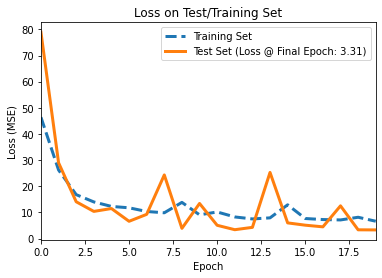

In [23]:
plt.xlim(0,len(history.history['loss'])-1)
plt.plot(history.history['loss'], linestyle='--', linewidth=3)
plt.plot(history.history['val_loss'], linewidth=3)
plt.title('Loss on Test/Training Set')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set (Loss @ Final Epoch: '+ str("%.2f"%score) +')'], loc='upper right')
plt.show()

Finally, we can select random images from the test set, and see how well the network predicts their summation:

In [24]:
for _ in range(10):
    ind = random.randint(0, len(X_test)-1)
    image_predicted = X_test[ind].copy()
    image_predicted = image_predicted.reshape((28, 56))
    image_predicted = image_predicted * 255
    image_predicted = image_predicted.astype('uint8')
    dp.display_png(Image.fromarray(image_predicted))
    p = model.predict(X_test[ind].reshape(1, 28, 56, 1))[0][0]
    print("Prediction for %s: %s" % (y_test[ind], p))

Prediction for 2: 4.5444775


Prediction for 14: 12.916745


Prediction for 9: 6.2585187


Prediction for 5: 7.5172806


Prediction for 6: 7.0708666


Prediction for 8: 9.813256


Prediction for 14: 12.985004


Prediction for 14: 14.344926


Prediction for 2: 5.115797


Prediction for 9: 9.574443


As we have created only 10 samples per permutation pair (compared to 1000 samples per permutation pair as was the case in the paper) the network does not perform as well as reported in the paper.

## Evaluation of Accuracy

Evaluating the accuracy of the model can also be done by rounding the predicted values to the nearest integer and comparing these to the actual labels:

In [25]:
correct = 0
incorrect = 0

for i in range(0, len(y_test)):
    prediction = model.predict(X_test[i].reshape(1, X_test[i].shape[0], X_test[i].shape[1], 1))[0][0]
    rounded_prediction = round(prediction)
    floor_prediction = floor(prediction)
    ceiling_prediction = ceil(prediction)
    
    abs_difference = abs(rounded_prediction-y_test[i])
    
    if abs_difference <= 1:
        correct = correct + 1
    else:
        incorrect = incorrect + 1
        
print("Correct: %s, incorrect: %s" % (correct, incorrect))

Correct: 58, incorrect: 42


# Ten Fold Cross Validation

In order to fully replicate the results in the paper, you can perform a 10 fold cross validation of the data by executing the code cell below. 

**This code cell performs all the steps above with 1,000 samples per permutation pair and trains the network over 100 epochs, using a 10 fold cross validation, in one go. Therefore, this will take a long time to execute.**

In [ ]:
unique_pairs = [str(x)+str(y) for x in range(10) for y in range(10)]
train_counter = 0

(X_train_keras, y_train_keras), (X_test_keras, y_test_keras) = mnist.load_data()

kf = KFold(n_splits=10, shuffle=True, random_state=376483)
kf.get_n_splits(unique_pairs)

unique_pairs_np = np.asarray(unique_pairs)
# Store network performance history and score for each of the training runs.
histories = []
scores = []

# Store accuracies measured in various ways
accuracies_rounded = []
accuracies_floor_ceil = []
accuracies_leeway = []


for train_index, test_index in kf.split(unique_pairs):
    test_set_pairs = unique_pairs_np[test_index]
    train_set_pairs = unique_pairs_np[train_index]
    
    # Sanity checks
    assert(len(test_set_pairs) == 10)
    assert(len(train_set_pairs) == 90)
    for test_set_pair in test_set_pairs:
        assert(test_set_pair not in train_set_pairs)
    
    # If these pass we are good to go with data generation
    X_train = []
    y_train = []

    # Number of samples per permutation (e.g. there are 90 permutations in the train 
    # set so 1000*90 makes 90,000 training samples and 10*1000=10,000 test samples)
    samples_per_permutation = 1000  

    for train_set_pair in train_set_pairs:
        for _ in range(samples_per_permutation):
            rand_i = np.random.choice(np.where(y_train_keras == int(train_set_pair[0]))[0])
            rand_j = np.random.choice(np.where(y_train_keras == int(train_set_pair[1]))[0])
        
            temp_image = np.zeros((28,56), dtype="uint8")
            temp_image[:,:28] = X_train_keras[rand_i]
            temp_image[:,28:] = X_train_keras[rand_j]

            X_train.append(temp_image)
            y_train.append(y_train_keras[rand_i] + y_train_keras[rand_j])
        
    X_test = []
    y_test = []
    
    for test_set_pair in test_set_pairs:
        for _ in range(samples_per_permutation):
            rand_i = np.random.choice(np.where(y_test_keras == int(test_set_pair[0]))[0])
            rand_j = np.random.choice(np.where(y_test_keras == int(test_set_pair[1]))[0])
        
            temp_image = np.zeros((28,56), dtype="uint8")
            temp_image[:,:28] = X_test_keras[rand_i]
            temp_image[:,28:] = X_test_keras[rand_j]
            
            X_test.append(temp_image)
            y_test.append(y_test_keras[rand_i] + y_test_keras[rand_j])
    
    
    # Explicitly convert to Numpy arrays, as they will be expected later
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test)

    # Reshape the data sets to a format suitable for Keras
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    
    # Some standard preprocessing things here.
    # Reformat the images to use floating point values rather than integers between 0-255
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255
    
    # Shuffling
    X_train, y_train = utils.shuffle(X_train, y_train)
    X_test, y_test = utils.shuffle(X_test, y_test)
    
    ######################################################
    # NETWORK SETUP AND TRAINING
    ######################################################
    # Set up a few constants related to the size of the 
    # network, number of output classes and so on.
    batch_size = 128
    # This is a regression problem and we will 
    # use a single neuron as output: this network is not 
    # being trained as a classification problem.
    num_classes = 1               
    epochs = 100
    img_rows, img_cols = np.shape(X_train)[1], np.shape(X_train)[2]
    input_shape = (img_rows, img_cols, 1)

    ######################################################
    # Set up the network itself
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))  # Default is (3, 3)
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))  # Default is 128
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    # Do not use softmax here, just specify one nueron
    model.add(Dense(num_classes)) # CHANGED TO LINEAR, REMOVE TO GO BACK TO DEFAULT

    ######################################################
    # Choose an optimiser and configure it.
    # Here we have initialised a number of optimisers, but 
    # we will use Root Mean Squared Propagation (RMSprop)
    rms = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    sgd = optimizers.SGD(lr=0.0001, decay=1e-5, momentum=0.9, nesterov=True)
    ada = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
    ndm = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)

    ######################################################
    # Compile the network.
    # Note: As this is a regression problem, only mean squared error 
    # or mean absolute error can be used for the loss.
    model.compile(loss=losses.mean_squared_error, optimizer=ada)
    
    ## LET'S TRAIN
    histories.append(model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    verbose=0))
    
    print("RUN %s" % train_counter)
    
    scores.append(model.evaluate(X_test, y_test, verbose=0))
    print(model.evaluate(X_test, y_test, verbose=1))
    
    rounded_correct = 0
    rounded_incorrect = 0
    floor_ceil_correct = 0
    floor_ceil_incorrect = 0
    leeway_correct = 0
    leeway_incorrect = 0

    for i in range(0, len(y_test)):
        prediction = model.predict(X_test[i].reshape(1, X_test[i].shape[0], X_test[i].shape[1], 1))[0][0]

        rounded_prediction = round(prediction)
        floor_prediction = floor(prediction)
        ceiling_prediction = ceil(prediction)

        # Rounded to the nearest integer
        if rounded_prediction == y_test[i]:
            rounded_correct += 1
        else:
            rounded_incorrect += 1

        # Floor or ceiling
        if (floor_prediction == y_test[i]) or (ceiling_prediction == y_test[i]):
            floor_ceil_correct += 1
        else:
            floor_ceil_incorrect += 1

        # Leeway of 1
        abs_difference = abs(rounded_prediction-y_test[i])

        if abs_difference <= 1:
            leeway_correct += 1
        else:
            leeway_incorrect += 1

    accuracies_rounded.append((rounded_correct, rounded_incorrect))
    accuracies_floor_ceil.append((floor_ceil_correct, floor_ceil_incorrect))
    accuracies_leeway.append((leeway_correct, leeway_incorrect))

    print("Correct (rounded): %s, Incorrect (rounded): %s" % (rounded_correct, rounded_incorrect))        
    print("Correct (floor/ceiling): %s, Incorrect (floor/ceiling): %s" % (floor_ceil_correct, floor_ceil_incorrect))
    print("Correct (leeway): %s, Incorrect (leeway): %s" % (leeway_correct, leeway_incorrect))
    
    print("END %s\n" % train_counter)
    
    train_counter += 1

Now you can print the losses of all ten folds:

In [ ]:
for history in histories:
    print("Train loss: %s Test loss: %s" % (history.history["loss"][-1], history.history["val_loss"][-1]))

The losses over all epochs can also be plotted for each of the train/test splits in the 10-fold cross validation:

In [ ]:
h_counter = 1
for history in histories:
    score = history.history['val_loss'][-1]
    plt.xlim(0,len(history.history['loss'])-1)
    plt.plot(history.history['loss'], linestyle='--', linewidth=3)
    plt.plot(history.history['val_loss'], linewidth=3)
    plt.title('Loss on Test/Training Set, Split %s' % h_counter)
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend(['Training Set', 'Test Set (Loss @ Final Epoch: '+ str("%.2f"%score) +')'], loc='upper right')
    #plt.savefig("/tmp/loss-100-epochs-%s-fold.pdf" % h_counter)
    plt.show()
    plt.close()
    h_counter += 1

## End of Notebook

Thank you for viewing this notebook. 

For questions please contact the maintainer of this repository, for contact details please see <https://github.com/mdbloice>